# QUORA: IDENTIFYING QUESTION PAIRS WITH THE SAME INTENT

### Importing the necessary libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud # Importing wordcloud library for checking the most frequently occuring words
%matplotlib inline  

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import seaborn as sns


### Exploring the dataset

In [3]:
# Loading the dataset
data = pd.read_csv("questions.csv" ,engine='python')
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Some Important Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
# Description of the dataset, in terms of count, mean , std dev etc.
data.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


Total number of questions in the dataset:  404351
Total number of duplicate questions in the dataset: 149306
Ratio of duplicate questions in the dataset: 36.92% 


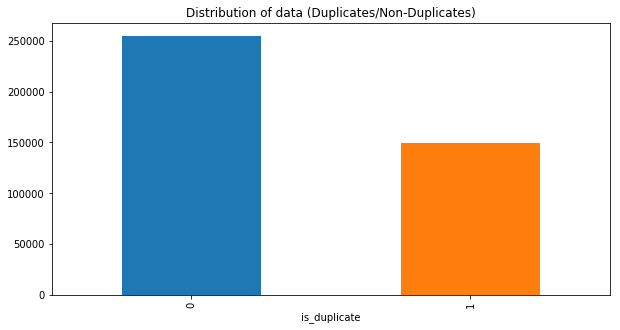

In [7]:
duplicate_questions = data['is_duplicate'].sum()     # Target Variable

print('Total number of questions in the dataset:  {}'.format(data.shape[0])) 
print('Total number of duplicate questions in the dataset: {}'.format(duplicate_questions)) 
print('Ratio of duplicate questions in the dataset: {:.2f}% '.format(100*duplicate_questions/data.shape[0]))
plt.figure(figsize=(10,5))
plt.title("Distribution of data (Duplicates/Non-Duplicates)")
data.groupby("is_duplicate")['id'].count().plot.bar()
plt.savefig("fig1.jpg")

### Data Preprocessing and Visualizing the dataset

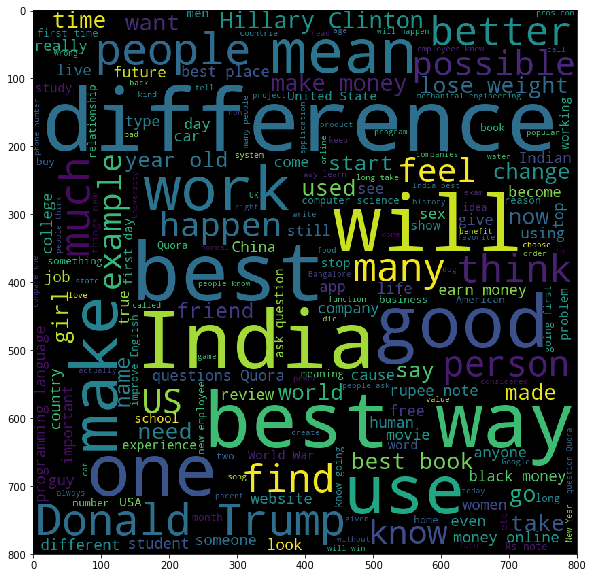

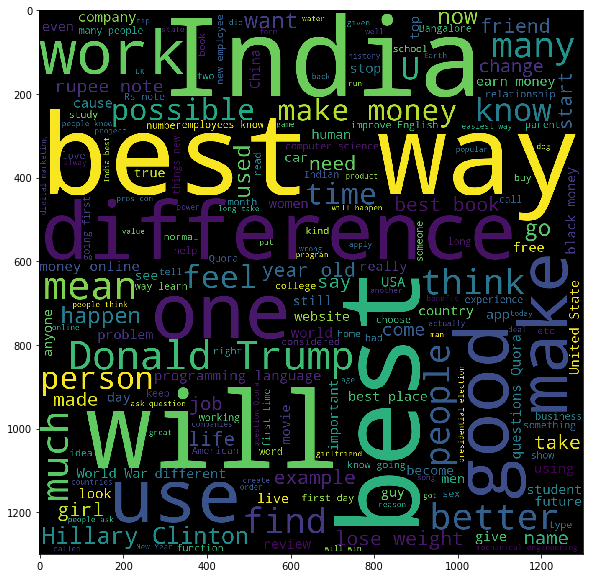

In [8]:

# Checking the most frequently occuring words
word_cloud_1 = WordCloud(width=800, height=800).generate(" ".join(data['question1'].astype(str)))
word_cloud_2 = WordCloud(width=1300, height=1300).generate(" ".join(data['question2'].astype(str)))

plt.figure(figsize=(14, 10))
plt.imshow(word_cloud_1)
plt.savefig("fig2.jpg")
plt.figure(figsize=(14, 10))
plt.imshow(word_cloud_2)
plt.savefig("fig3.jpg")

Observation: The above two plots clearly shows that there are some frequently occuring common words in the two questions (question1 and question2). For example: 'difference', ' Donald Trump' etc.

###### Note: Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

In [9]:
"""
Function to calculate normalized word share between two questions

Equation: {(Common Length of two questions (Shortest Length among the two questions)) / 
                    ((Length of Question 1) + (Length of Question 2))}
"""

def word_share(x):
    word_1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    word_2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))
    return 1.0 * len(word_1 & word_2)/(len(word_1) + len(word_2))

In [10]:
"""
Function to calculate TF-IDF word share between two questions

"""
def tfidf_word_share(x):    
    count_vectorizer = CountVectorizer()
    document = []
    document.append(str(x['question1']))
    document.append(str(x['question2']))
    freq_term_matrix = count_vectorizer.fit_transform(document)
    tfidf = TfidfTransformer(norm="l2")
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix_1 = tfidf.transform(freq_term_matrix)
    arr = cosine_similarity(tf_idf_matrix_1[0:1], tf_idf_matrix_1)
    return arr[0][1]

In [11]:
"""
Features Construction:
1. length
2. number of words
3. word share 
4. tf-idf word share

""" 
new_data = pd.DataFrame(dtype='float64')
new_data['q1_length'] = data['question1'].str.len()   # Length of the question 1
new_data['q2_length'] = data['question2'].str.len()   # Length of the question 2
new_data['q1_words_num'] = data['question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_data['q2_words_num'] = data['question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_data['word_share'] = data.apply(word_share, axis=1) # Calculating word share between the two questions
new_data['TFIDF_share'] = data.apply(tfidf_word_share, axis=1, raw=True) # Calculating the tf-tdf word share between the two questions

new_data.head()

,q1_length,q2_length,q1_words_num,q2_words_num,word_share,TFIDF_share
0,66.0,57.0,14,12,0.434783,0.920307
1,51.0,88.0,8,13,0.200000,0.424251
2,73.0,59.0,14,10,0.166667,0.225765
3,50.0,65.0,11,9,0.000000,0.000000
4,76.0,39.0,13,7,0.100000,0.272060


In [12]:
# Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(new_data))
new_data.loc[:,['q2_length','q1_length','word_share','TFIDF_share']] = np.nan_to_num(new_data.loc[:,['q2_length','q1_length'   \
                                                                                                     ,'word_share','TFIDF_share']])
np.sum(np.isnan(new_data))

q1_length       0
q2_length       0
q1_words_num    0
q2_words_num    0
word_share      0
TFIDF_share     0
dtype: int64

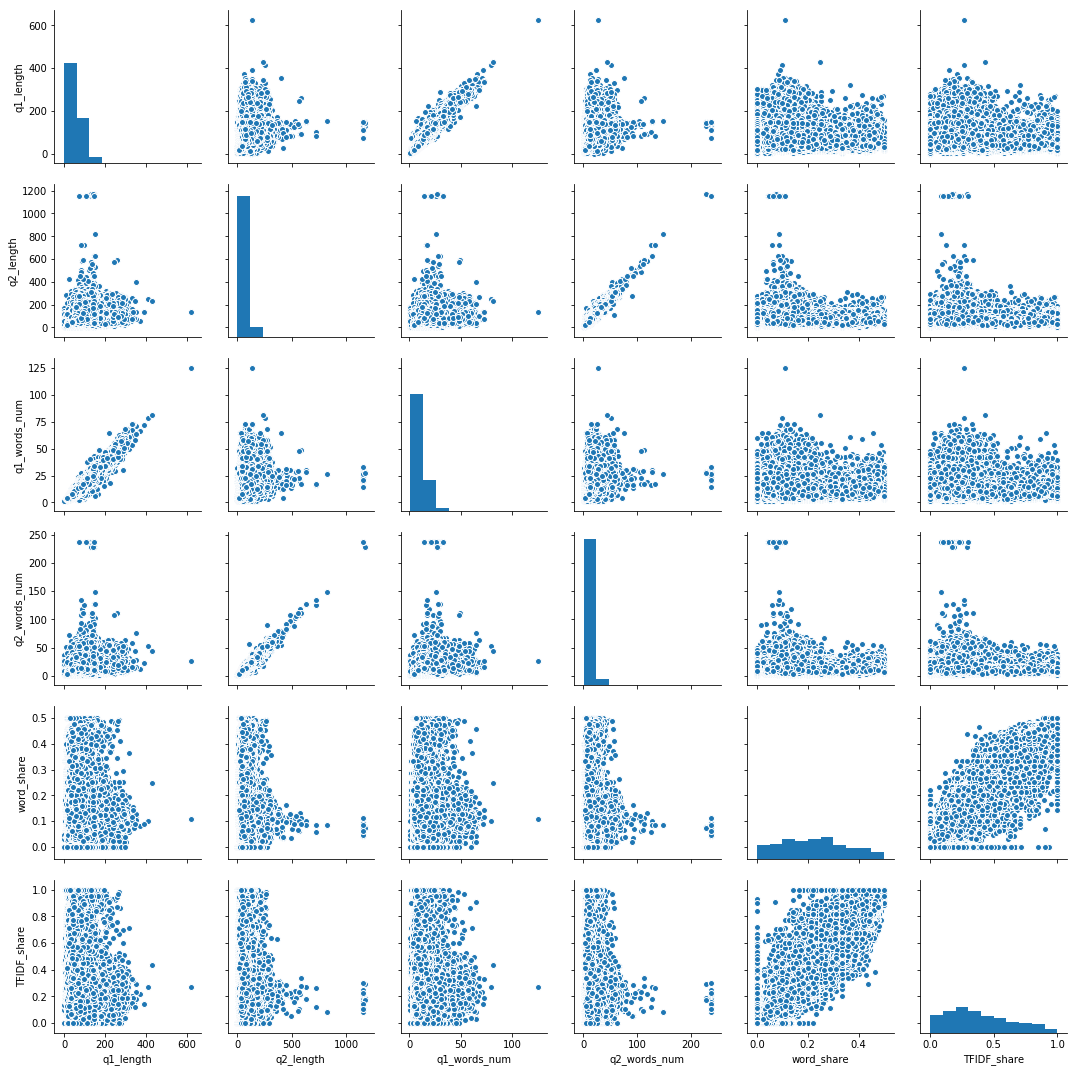

In [13]:
# Plotting the pairwise relationships in a dataset.
new_data_plot = new_data
sns.pairplot(new_data_plot);
plt.savefig("fig4.jpg")

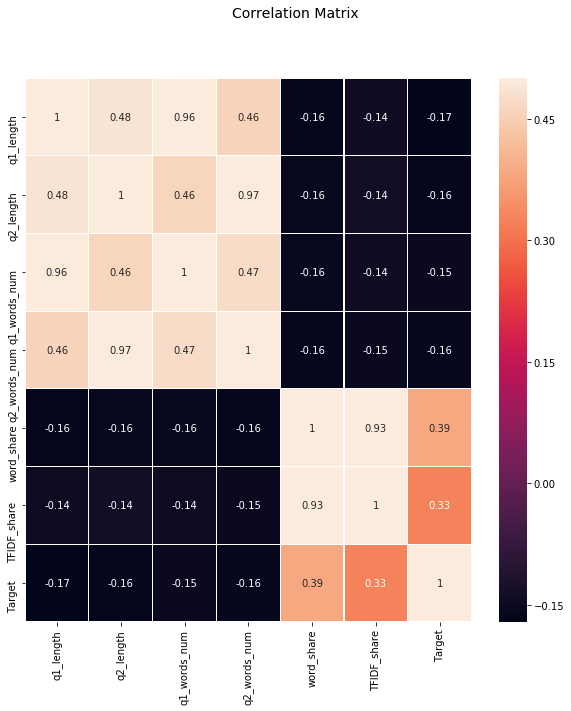

In [16]:
# Correlation between the features
new_data_plot['Target'] = data['is_duplicate']   # Length of the question 1

# calculate correlation
data_corr = new_data_plot.corr()

# plot correlation matrix
fig = plt.figure(figsize=(10, 10))
mask = np.zeros_like(data_corr, dtype=np.bool) # create mask to cover the upper triangle
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_corr, annot=True, vmax=0.5,linewidths=0.1)
fig.suptitle('Correlation Matrix', fontsize=14)
plt.savefig("fig5.jpg")

Observation: The above correlation matrix clearly shows that there is a high positive correlation between word_share, TF-IDF_Share and the target (indicating whether a question is duplicate or not) with correlation coefficient of 0.39, 0.32 respectively, which makes sense too. 

"\nplt.figure(figsize=(20, 10))\nplt.hist(new_data['q1_length'], bins=400, range=[0, 400], color='green', normed=True, label='Q1')\nplt.hist(new_data['q2_length'], bins=400, range=[0, 400], color='yellow',alpha = 0.5, normed=True, label='Q2')\nplt.title('Normalised histogram of character count in questions', fontsize=15)\nplt.legend()\nplt.xlabel('Number of characters', fontsize=15)\nplt.ylabel('Probability', fontsize=15)\n"

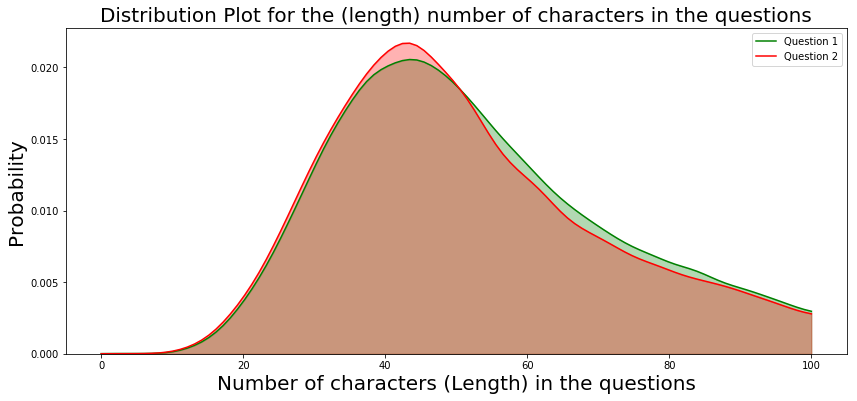

In [17]:
# Visualisation based on the feature : Length (Character Count)

plt.figure(figsize=(14, 6))
plt.title('Distribution Plot for the (length) number of characters in the questions', fontsize=20)
plt.ylabel('Probability', fontsize=20)
ax = sns.distplot(new_data['q1_length'], color='green', hist=False,fit_kws={"color":"green"}, kde_kws={"clip": [0,100]}, label = 'Question 1')
ax = sns.distplot(new_data['q2_length'], color='red', hist=False,fit_kws={"color":"red"},  kde_kws={"clip": [0,100]}, label = 'Question 2')
plt.legend()

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="green", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
plt.xlabel('Number of characters (Length) in the questions', fontsize=20)
plt.savefig("fig6.jpg")
"""
plt.figure(figsize=(20, 10))
plt.hist(new_data['q1_length'], bins=400, range=[0, 400], color='green', normed=True, label='Q1')
plt.hist(new_data['q2_length'], bins=400, range=[0, 400], color='yellow',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
"""


Observation: The above plot clearly shows that most of the questions are of length : 40-50

"\nplt.figure(figsize=(12, 8))\nplt.hist(new_data['q1_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')\nplt.hist(new_data['q2_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')\nplt.title('Normalized histogram of word count in questions', fontsize=15)\nplt.legend()\nplt.xlabel('Number of words', fontsize=15)\nplt.ylabel('Probability', fontsize=15)\n\n"

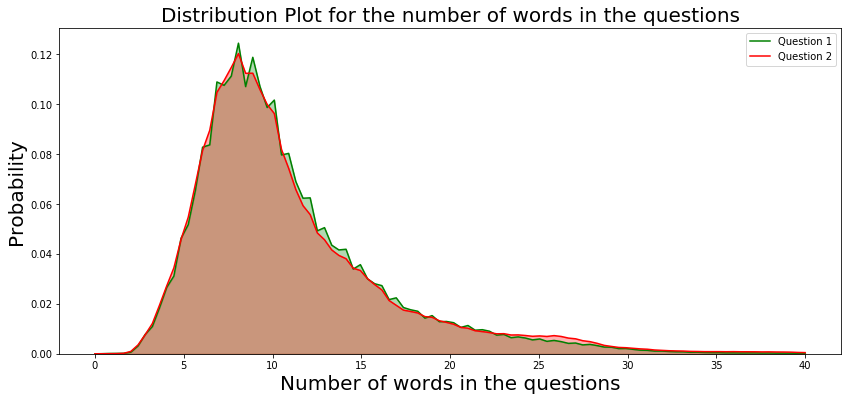

In [18]:
# Visualisation based on the feature : Number of words in the question

plt.figure(figsize=(14,6))
plt.title('Distribution Plot for the number of words in the questions', fontsize=20)
plt.ylabel('Probability', fontsize=20)
ax= sns.distplot(new_data['q1_words_num'], color='green', hist=False,fit_kws={"color":"blue"}, kde_kws={"clip": [0,40]}, label = 'Question 1')
ax = sns.distplot(new_data['q2_words_num'], color='red', hist=False,fit_kws={"color":"red"},  kde_kws={"clip": [0,40]}, label = 'Question 2')
plt.legend()

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="green", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
plt.xlabel('Number of words in the questions', fontsize=20)
plt.savefig("fig7.jpg")

"""
plt.figure(figsize=(12, 8))
plt.hist(new_data['q1_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(new_data['q2_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

"""






Observation: The above plot clearly shows that most of the questions have 7-11 words.

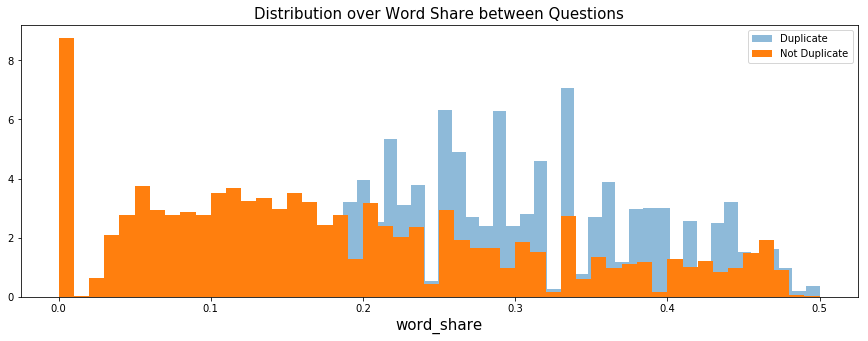

In [19]:
# Visualisation based on the feature : Word Share

plt.figure(figsize=(15, 5))
plot_word_share = new_data['word_share']
plt.hist(plot_word_share[data['is_duplicate'] == 1], bins=50, normed=True, alpha=0.5, label='Duplicate')
plt.hist(plot_word_share[data['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.legend()
plt.title('Distribution over Word Share between Questions', fontsize=15)
plt.xlabel('word_share', fontsize=15)
plt.savefig("fig8.jpg")

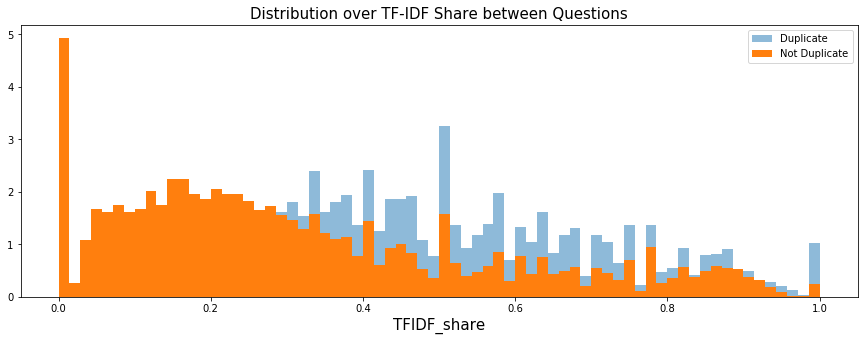

In [20]:
# Visualisation based on the feature : TF-IDF Word Share
plt.figure(figsize=(15, 5))
plot_tfidf_share = new_data['TFIDF_share']
plt.hist(plot_tfidf_share[data['is_duplicate'] == 1], bins=70, normed=True, alpha=0.5, label='Duplicate')
plt.hist(plot_tfidf_share[data['is_duplicate'] == 0], bins=70, normed=True, label='Not Duplicate')
plt.legend()
plt.title('Distribution over TF-IDF Share between Questions', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)
plt.savefig("fig9.jpg")

Observation: The above two plots clearly shows that the ratio of both word share and tf-idf word share is higher for duplicate questions than for non-duplicate questions.